# Load and imports

In [129]:
import pandas as pd
import numpy as np
import warnings
import numpy as np
import pandas as pd
from keras.layers import Dense, LSTM, Dropout
from keras.models import Sequential
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import h2o

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
import pickle
from h2o.automl import H2OAutoML

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from keras.callbacks import EarlyStopping

warnings.filterwarnings('ignore')

df05ht = pd.read_csv('data_live_scores_full.csv', encoding='utf-8')
print(df05ht.shape)

(1155173, 37)


In [130]:
df05ht

,date,minute,homeTeam,awayTeam,goalHome,goalAway,shotsHome,shotsAway,crossesHome,crossesAway,...,fouls_c_home,fouls_c_away,fouls_won_home,fouls_won_away,offsides_home,offsides_away,tackles_home,tackles_away,result,match_id
0,2020-01-09,90+4:21,FC Barcelona,Club Atlético de Madrid,2.0,3.0,16.0,6.0,6.0,2.0,...,18.0,14.0,14.0,16.0,2.0,2.0,13.0,19.0,0,2020-01-09-FC Barcelona-Club Atlético de Madrid
1,2020-01-09,90+3:42,FC Barcelona,Club Atlético de Madrid,2.0,3.0,16.0,6.0,6.0,2.0,...,18.0,14.0,14.0,16.0,2.0,2.0,13.0,19.0,0,2020-01-09-FC Barcelona-Club Atlético de Madrid
2,2020-01-09,90+3:02,FC Barcelona,Club Atlético de Madrid,2.0,3.0,16.0,6.0,6.0,2.0,...,18.0,14.0,14.0,16.0,2.0,2.0,13.0,19.0,0,2020-01-09-FC Barcelona-Club Atlético de Madrid
3,2020-01-09,90+2:23,FC Barcelona,Club Atlético de Madrid,2.0,3.0,15.0,6.0,6.0,2.0,...,18.0,14.0,14.0,16.0,2.0,2.0,13.0,19.0,0,2020-01-09-FC Barcelona-Club Atlético de Madrid
4,2020-01-09,90+1:44,FC Barcelona,Club Atlético de Madrid,2.0,3.0,15.0,6.0,6.0,2.0,...,18.0,14.0,14.0,16.0,2.0,2.0,12.0,19.0,0,2020-01-09-FC Barcelona-Club Atlético de Madrid
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1155168,2023-11-28,2:42,Ross County FC,Saint Mirren FC,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0,2023-11-28-Ross County FC-Saint Mirren FC
1155169,2023-11-28,2:03,Ross County FC,Saint Mirren FC,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,2023-11-28-Ross County FC-Saint Mirren FC
1155170,2023-11-28,1:24,Ross County FC,Saint Mirren FC,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,2023-11-28-Ross County FC-Saint Mirren FC
1155171,2023-11-28,0:45,Ross County FC,Saint Mirren FC,0.0,NaN,0.0,NaN,1.0,NaN,...,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0,2023-11-28-Ross County FC-Saint Mirren FC


In [131]:
date_object = pd.to_datetime(df05ht['date'], format='%Y-%m-%d')

min_date = date_object.min()
max_date = date_object.max()

print("Os dados vão de {} até {}".format(min_date, max_date))

Os dados vão de 2020-01-08 00:00:00 até 2023-12-01 00:00:00


In [132]:
df05ht.columns

Index(['date', 'minute', 'homeTeam', 'awayTeam', 'goalHome', 'goalAway',
       'shotsHome', 'shotsAway', 'crossesHome', 'crossesAway', 'assistsHome',
       'assistsAway', 'blockedShotsHome', 'blockedShotsAway', 'league',
       'corners_home', 'corners_away', 'redcards_home', 'redcards_away',
       'shotsOffgoal_home', 'shotsOffgoal_away', 'shotsOngoal_home',
       'shotsOngoal_away', 'yellowcards_home', 'yellowcards_away',
       'passes_home', 'passes_away', 'fouls_c_home', 'fouls_c_away',
       'fouls_won_home', 'fouls_won_away', 'offsides_home', 'offsides_away',
       'tackles_home', 'tackles_away', 'result', 'match_id'],
      dtype='object')

# Analisando e tratando os dados

## Limpeza

In [133]:
df = df05ht.copy()
print(f'Dimensão do DataFrame antes remoção: {df05ht.shape}')
print(f'Valores únicos de minutos antes da conversão: {df05ht.minute.unique()} \n')
registros_duplicados = len(df05ht[df05ht.duplicated()])
print(f'Registros duplicados: {registros_duplicados}')
df.drop_duplicates(keep='last', inplace=True)

registros_nulos = df.isnull().sum().sum()
print(f'Registros nulos: {registros_nulos}\n')
df.dropna(inplace=True)

# Convertendo os minutos para inteiros
df['minute_converted'] = df05ht['minute'].str.extract('(\d+)').astype(int)

# Removendo os minutos iguais a 0
df = df[df['minute_converted'] != 0]

# removendo minutos > 45
df = df[df['minute_converted'] <= 45]

df['minute'] = df['minute_converted']
df.drop(columns=['minute_converted'], inplace=True)
# print(f'Jogos que serão retirados: {len(invalid_ids)}\n')

print(f'Dimensão do DataFrame após remoção: {df.shape}')
print(f'Total de registros retirados: {df05ht.shape[0] - df.shape[0]}')

Dimensão do DataFrame antes remoção: (1155173, 37)
Valores únicos de minutos antes da conversão: ['90+4:21' '90+3:42' '90+3:02' ... '33:55' '16:47' '5:22'] 

Registros duplicados: 70
Registros nulos: 39570

Dimensão do DataFrame após remoção: (566300, 37)
Total de registros retirados: 588873


In [134]:
df_copy = df.copy()

In [136]:
df = df_copy.copy()

janela_tempo = 5

# definindo janela de tempo após acontecimento do evento (gol casa ou fora)
df_not_goal = df[(df['goalHome'] == 0) & (df['goalAway'] == 0)] # dataframe sem gol
df_goal1 = df[(df['goalHome'] == 0) & (df['goalAway'] == 1)] # dataframe com gol fora
df_goal2 = df[(df['goalHome'] == 1) & (df['goalAway'] == 0)] # dataframe com gol casa

df = pd.concat([df_not_goal, df_goal1, df_goal2], axis=0)
df.sort_values(by=['match_id', 'minute'], inplace=True) # ordenando por match_id e minuto

# adicionar a cada match_id (partida) os ultimos 10 registros antes do gol 1 a coluna result
for match_id in df['match_id'].unique():
    last_10 = df[df['match_id'] == match_id].tail(janela_tempo)

    # Atualize a coluna 'result' para 1 nesses registros
    df.loc[last_10.index, 'result'] = 1

df.shape

(489578, 37)

In [137]:
df_trated = df.copy()

In [ ]:
df[df['match_id'] == '2020-01-08-Valencia CF-Real Madrid CF'] # exemplo de como ficou

## Seleção de Ligas, Cálculo de Posse de Bola e Limpeza do DataFrame

In [138]:
# Calculando o tempo de posse de bola
total_passes = df['passes_away'] + df['passes_home']
df['possessiontime_away'] = round((df['passes_away'] / total_passes) * 100)
df['possessiontime_home'] = round((df['passes_home'] / total_passes) * 100)

df['possessiontime_home'].fillna(method='bfill', inplace=True)
df['possessiontime_away'].fillna(method='bfill', inplace=True)

print("\nDados de posse de bola:\n", df[['possessiontime_away', 'possessiontime_home']].head())

# Renomeando colunas
new_column_names = {'fouls_won_away': 'fouls_away', 'fouls_won_home': 'fouls_home'}
df.rename(columns=new_column_names, inplace=True)
print("\nColunas renomeadas:\n", df.columns)

# Removendo colunas desnecessárias e limpando o DataFrame
columns_to_drop = ["date", 'passes_home', 'passes_away', 'fouls_c_home', 'fouls_c_away','goalHome', 'goalAway', 'crossesHome', 'crossesAway', 'assistsHome',
       'assistsAway',]
df.drop(columns=columns_to_drop, inplace=True)
print("\nDataFrame após remover colunas:\n", df.columns)

df.reset_index(drop=True, inplace=True)
print(f'Dimensão do DataFrame após modificações: {df.shape}')
df.isnull().sum()


Dados de posse de bola:
        possessiontime_away  possessiontime_home
14928                 95.0                  5.0
14929                 93.0                  7.0
14927                 85.0                 15.0
14925                 86.0                 14.0
14926                 87.0                 13.0

Colunas renomeadas:
 Index(['date', 'minute', 'homeTeam', 'awayTeam', 'goalHome', 'goalAway',
       'shotsHome', 'shotsAway', 'crossesHome', 'crossesAway', 'assistsHome',
       'assistsAway', 'blockedShotsHome', 'blockedShotsAway', 'league',
       'corners_home', 'corners_away', 'redcards_home', 'redcards_away',
       'shotsOffgoal_home', 'shotsOffgoal_away', 'shotsOngoal_home',
       'shotsOngoal_away', 'yellowcards_home', 'yellowcards_away',
       'passes_home', 'passes_away', 'fouls_c_home', 'fouls_c_away',
       'fouls_home', 'fouls_away', 'offsides_home', 'offsides_away',
       'tackles_home', 'tackles_away', 'result', 'match_id',
       'possessiontime_away', 'po

minute                 0
homeTeam               0
awayTeam               0
shotsHome              0
shotsAway              0
blockedShotsHome       0
blockedShotsAway       0
league                 0
corners_home           0
corners_away           0
redcards_home          0
redcards_away          0
shotsOffgoal_home      0
shotsOffgoal_away      0
shotsOngoal_home       0
shotsOngoal_away       0
yellowcards_home       0
yellowcards_away       0
fouls_home             0
fouls_away             0
offsides_home          0
offsides_away          0
tackles_home           0
tackles_away           0
result                 0
match_id               0
possessiontime_away    0
possessiontime_home    0
dtype: int64

## Tratando o formato das ligas para ligas existentes 

In [139]:
# Obtendo ligas únicas
leagues_opta = df['league'].unique()
print("Ligas únicas:", leagues_opta)

# Iterando através das ligas únicas
for league in leagues_opta:
    print("Liga atual:", league)

# Mapeamento de nomes de ligas
name_mapping = {
    'England - Premier League': 'England - Premier League',
    'Germany - Bundesliga': 'Germany - Bundesliga',
    'Spain - Primera División': 'Spain - La Liga',
    'France - Ligue 1': 'France - Ligue 1',
    'Italy - Serie A': 'Italy - Serie A',
    'USA - MLS': 'USA - Major League Soccer',
    'Brazil - Serie A': 'Brazil - Serie A',
    'Netherlands - Eredivisie': 'Netherlands - Eredivisie',
    'England - Championship': 'England - Championship',
    'Portugal - Primeira Liga': 'Portugal - Liga Portugal',
    'Romania - Liga I': 'Romania - Liga 1',
    "World - FIFA Women's World Cup": 'World - World Cup Women',
    'England - League One': 'England - League One',
    'England - League Two': 'England - League Two',
    'Europe - UEFA Europa Conference League': 'Europe - Europa Conference League',
    'England - League Cup': 'England - Carabao Cup',
    'Europe - UEFA Super Cup': 'Europe - Uefa Super Cup',
    'Europe - UEFA Champions League': 'Europe - Champions League',
    'Germany - DFB Pokal': 'Germany - DFB Pokal',
    'Italy - Coppa Italia': 'Italy - Coppa Italia',
    'Scotland - Premiership': 'Scotland - Premiership',
    'Germany - Super Cup': 'Germany - Super Cup',
    'South America - CONMEBOL Libertadores': 'South America - Copa Libertadores',
    'England - Community Shield': 'England - Community Shield',
    'N/C America - Concacaf Gold Cup': 'World - CONCACAF Gold Cup',
    'Europe - UEFA U21 Championship': 'Europe - Euro U21',
    'Australia - A-League Men': 'Australia - A-League',
    'Portugal - Play-offs 1/2': 'Portugal - Primeira Liga - Play-offs',
    'Europe - UEFA European Championship Qualifiers': 'Europe - Euro Qualification',
    'Germany - Play-offs 1/2': 'Germany - Bundesliga Play-offs',
    'Europe - UEFA Nations League': 'Europe - UEFA Nations League',
    'Europe - UEFA Europa League': 'Europe - Europa League',
    'England - FA Cup': 'England - FA Cup',
    'Spain - Copa del Rey': 'Spain - Copa Del Rey',
    'World - FIFA World Cup': 'World - FIFA World Cup',
    'France - Coupe de France': 'France - Coupe de France',
    'Spain - Super Cup': 'Spain - Super Cup',
    'Italy - Super Cup': 'Italy - Super Cup',
    'World - FIFA Club World Cup': 'World - FIFA Club World Cup',
    'Argentina - Liga Profesional Argentina': "Argentina - Superliga",
    'Brazil - Paulista A1': 'Brazil - Paulista A1',
    'Brazil - Copa do Brasil': 'Brazil - Copa Do Brasil',
    'Denmark - Superliga':'Denmark - Superliga',
    'Mexico - Liga MX': 'Mexico - Liga MX',
    'Greece - Super League 1': 'Greece - Super League',
    'Asia - AFC Champions League': 'Asia - AFC Champions League', 
    'South America - CONMEBOL Sudamericana': 'South America - Copa Sudamericana', 
    'Spain - Segunda División': 'Spain - La Liga 2',
    'Saudi Arabia - Saudi League': 'Saudi Arabia - Pro League',
    'Italy - Serie B': 'Italy - Serie B',
    'Japan - J1 League': 'Japan - J-League',
    'South America - CONMEBOL World Cup Qualifiers': 'World - WC Qualification South America',
    'Europe - UEFA World Cup Qualifiers': 'Europe - WC Qualification Europe', 
    "Europe - UEFA Women's Championship": "Europe - UEFA Women's EURO",
    "France - Trophée des Champions": 'France - Super Cup',
    'Brazil - Supercopa do Brasil': 'Brazil - Supercopa do Brasil',
    'South America - CONMEBOL Recopa': 'South America - Recopa Sudamericana',
    'Europe - UEFA European Championship': 'Europe - European Championship', 
    'N/C America - Leagues Cup': 'North & Central America - Leagues Cup',
    'South America - CONMEBOL Copa America': 'South America - Copa America',

}
print("\nTamanho do mapeamento de nomes de ligas:", len(name_mapping))

# Verificando o número de ligas únicas
print("Número de ligas únicas:", len(leagues_opta))
print("Número de ligas únicas após o mapeamento:", len(name_mapping))

# Atualizando os nomes das ligas no DataFrame
df['league'] = df['league'].replace(name_mapping)

# Verificando algumas linhas do DataFrame após a atualização dos nomes das ligas
# print("\nDataFrame após atualizar os nomes das ligas:\n", df['league'].unique())
for league in df['league'].unique():
    print("Liga atual no dataframe:", league)

Ligas únicas: ['Spain - Super Cup' 'South America - CONMEBOL Libertadores'
 'Asia - AFC Champions League' 'Brazil - Paulista A1'
 'South America - CONMEBOL Sudamericana' 'Brazil - Copa do Brasil'
 'Brazil - Supercopa do Brasil' 'South America - CONMEBOL Recopa'
 'Japan - J1 League' 'USA - MLS' 'Germany - Play-offs 1/2'
 'Mexico - Liga MX' 'Scotland - Premiership' 'Brazil - Serie A'
 'France - Ligue 1' 'Europe - UEFA Champions League'
 'England - Community Shield' 'England - League Cup'
 'Europe - UEFA Nations League' 'Greece - Super League 1'
 'Germany - DFB Pokal' 'Denmark - Superliga' 'England - Championship'
 'England - League One' 'England - League Two' 'England - Premier League'
 'Spain - Primera División' 'Netherlands - Eredivisie'
 'Spain - Segunda División' "Europe - UEFA Women's Championship"
 'Europe - UEFA Europa League' 'Germany - Bundesliga'
 'Portugal - Primeira Liga' 'Italy - Serie A' 'Europe - UEFA Super Cup'
 'Italy - Serie B' 'Germany - Super Cup'
 'South America - CO

Liga atual no dataframe: Spain - Super Cup
Liga atual no dataframe: South America - Copa Libertadores
Liga atual no dataframe: Asia - AFC Champions League
Liga atual no dataframe: Brazil - Paulista A1
Liga atual no dataframe: South America - Copa Sudamericana
Liga atual no dataframe: Brazil - Copa Do Brasil
Liga atual no dataframe: Brazil - Supercopa do Brasil
Liga atual no dataframe: South America - Recopa Sudamericana
Liga atual no dataframe: Japan - J-League
Liga atual no dataframe: USA - Major League Soccer
Liga atual no dataframe: Germany - Bundesliga Play-offs
Liga atual no dataframe: Mexico - Liga MX
Liga atual no dataframe: Scotland - Premiership
Liga atual no dataframe: Brazil - Serie A
Liga atual no dataframe: France - Ligue 1
Liga atual no dataframe: Europe - Champions League
Liga atual no dataframe: England - Community Shield
Liga atual no dataframe: England - Carabao Cup
Liga atual no dataframe: Europe - UEFA Nations League
Liga atual no dataframe: Greece - Super League
Li

## Balanceamento de Dados e Visualização da Distribuição de Resultados por Liga

Contando partidas por time...
Total de partidas: 7813

Filtrando dados de ligas...
Dados filtrados:

league
USA - Major League Soccer            33143
Brazil - Serie A                     26322
Argentina - Superliga                25649
England - Championship               23992
England - League Two                 21735
England - League One                 21393
Japan - J-League                     20039
Spain - La Liga 2                    18821
Mexico - Liga MX                     16475
South America - Copa Libertadores    14702
Spain - La Liga                      13568
Europe - Champions League            13441
Italy - Serie B                      13336
England - Premier League             12719
Europe - UEFA Nations League         12486
Europe - Europa League               12348
Saudi Arabia - Pro League            12326
France - Ligue 1                     12321
Italy - Serie A                      12321
Asia - AFC Champions League          11937
South America - Copa Sudamerican

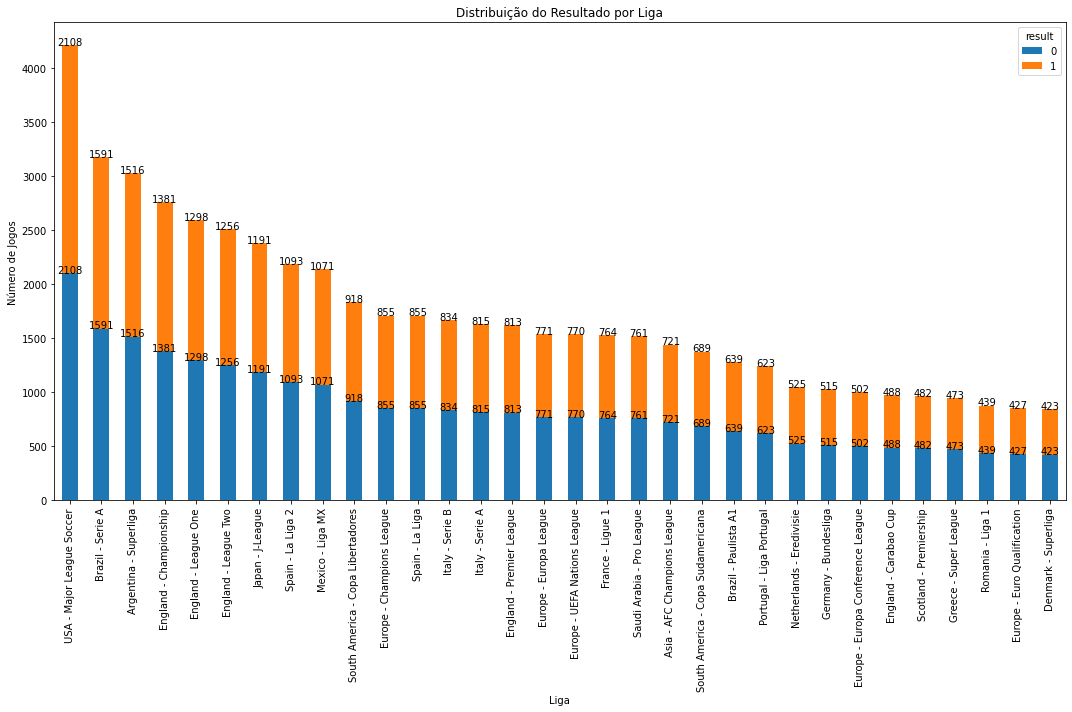

<Figure size 432x288 with 0 Axes>

In [140]:
import pandas as pd
import matplotlib.pyplot as plt

def filter_leagues(df, league_col, matches, min_matches=100):
    """Filtra ligas com base no número de partidas e na diversidade de resultados."""
    league_game_counts = df.groupby(league_col)[matches].nunique()
    leagues_filtered = league_game_counts[league_game_counts >= min_matches].index
    filtered_data = df[df[league_col].isin(leagues_filtered)]
    return filtered_data

# def balance_data(df, league_col='league', result_col='result'):
#     leagues = df[league_col].unique()
#     balanced_dfs = []
#     for league in leagues:
#         league_df = df[df[league_col] == league]
        

#         result_counts = league_df[result_col].value_counts()
#         min_count = result_counts.min()
#         balanced_league_df = pd.concat([
#             league_df[league_df[result_col] == 0].sample(min_count, random_state=42),
#             league_df[league_df[result_col] == 1].sample(min_count, random_state=42)
#         ])
#         balanced_dfs.append(balanced_league_df)
#     balanced_data = pd.concat(balanced_dfs).reset_index(drop=True)
#     return balanced_data

def balance_data(df, league_col='league', result_col='result'):
    # Removendo duplicatas do DataFrame original
    df = df.drop_duplicates()

    leagues = df[league_col].unique()
    balanced_dfs = []
    for league in leagues:
        league_df = df[df[league_col] == league]

        result_counts = league_df[result_col].value_counts()
        min_count = result_counts.min()

        for result in league_df[result_col].unique():
            sample_size = min(min_count, result_counts[result])
            sampled_df = league_df[league_df[result_col] == result].sample(sample_size, random_state=42)
            balanced_dfs.append(sampled_df)

    balanced_data = pd.concat(balanced_dfs).reset_index(drop=True)

    # Removendo duplicatas após a concatenação, caso existam
    # balanced_data = balanced_data.drop_duplicates()

    return balanced_data


print("Contando partidas por time...")
total_matches_per_team = len(df['match_id'].unique())
print("Total de partidas:", total_matches_per_team)

print("\nFiltrando dados de ligas...")
filtered_data = filter_leagues(df, 'league', 'match_id')
print("Dados filtrados:\n")
print(filtered_data['league'].value_counts())

print("\nBalanceando dados...")
balanced_data = balance_data(filtered_data)
print("Dados balanceados:\n")
print(balanced_data['result'].value_counts())

# balanced_data.drop_duplicates(keep='last', inplace=True)
# balanced_data.dropna(inplace=True)

league_distribution = balanced_data.groupby(['league', 'result']).size().unstack()
sorted_leagues = league_distribution.sum(axis=1).sort_values(ascending=False).head(100).index

print("Contando partidas depois dos filtros...")
total_matches_per_team = len(balanced_data['match_id'].unique())
print("Total de partidas:", total_matches_per_team)

plt.figure(figsize=(15, 10))
ax = league_distribution.loc[sorted_leagues].plot(kind='bar', stacked=True, ax=plt.gca())
plt.title('Distribuição do Resultado por Liga')
plt.ylabel('Número de Jogos')
plt.xlabel('Liga')
plt.tight_layout()
plt.xticks(rotation=90)

for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy() 
    ax.annotate(f'{height:.0f}', (x + width/2, y + height), ha='center')

plt.show()
plt.clf()  

In [141]:
balanced_data

,minute,homeTeam,awayTeam,shotsHome,shotsAway,blockedShotsHome,blockedShotsAway,league,corners_home,corners_away,...,fouls_home,fouls_away,offsides_home,offsides_away,tackles_home,tackles_away,result,match_id,possessiontime_away,possessiontime_home
0,11,CSD Defensa y Justicia,Club Olimpia,0.0,0.0,0.0,0.0,South America - Copa Libertadores,0.0,1.0,...,2.0,0.0,1.0,3.0,6.0,5.0,0,2020-09-23-CSD Defensa y Justicia-Club Olimpia,37.0,63.0
1,5,Club Atlético Nacional SA,Club Guaraní,0.0,2.0,0.0,1.0,South America - Copa Libertadores,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,1.0,0,2021-03-19-Club Atlético Nacional SA-Club Guaraní,62.0,38.0
2,20,Club Nacional de Football,CA River Plate,2.0,3.0,0.0,0.0,South America - Copa Libertadores,1.0,0.0,...,3.0,4.0,0.0,0.0,5.0,5.0,0,2020-12-18-Club Nacional de Football-CA River ...,53.0,47.0
3,11,América FC (Minas Gerais),CSD Independiente del Valle,3.0,0.0,1.0,0.0,South America - Copa Libertadores,1.0,0.0,...,2.0,0.0,1.0,0.0,2.0,1.0,0,2022-04-06-América FC (Minas Gerais)-CSD Indep...,41.0,59.0
4,35,CR Flamengo,Club Sporting Cristal SA,9.0,3.0,1.0,0.0,South America - Copa Libertadores,1.0,1.0,...,2.0,1.0,0.0,2.0,7.0,7.0,0,2022-05-25-CR Flamengo-Club Sporting Cristal SA,40.0,60.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55209,13,Luxembourg,Portugal,2.0,1.0,1.0,0.0,Europe - Euro Qualification,0.0,0.0,...,1.0,0.0,0.0,1.0,3.0,4.0,1,2023-03-26-Luxembourg-Portugal,64.0,36.0
55210,45,Switzerland,Israel,4.0,2.0,1.0,0.0,Europe - Euro Qualification,2.0,1.0,...,4.0,3.0,0.0,0.0,7.0,6.0,1,2023-03-28-Switzerland-Israel,28.0,72.0
55211,19,Greece,Gibraltar,5.0,0.0,0.0,0.0,Europe - Euro Qualification,3.0,0.0,...,0.0,1.0,0.0,0.0,2.0,3.0,1,2023-09-10-Greece-Gibraltar,15.0,85.0
55212,45,Faroe Islands,Poland,1.0,7.0,0.0,3.0,Europe - Euro Qualification,2.0,2.0,...,4.0,10.0,0.0,1.0,4.0,7.0,1,2023-10-12-Faroe Islands-Poland,57.0,43.0


In [142]:
balanced_data.to_csv("data_balanced.csv", index=False, encoding='utf-8')

In [144]:
balanced_data.value_counts('result')

result
0    27607
1    27607
Name: count, dtype: int64